# XGBoost Model (Without Market Cap Restriction)
本模型採用 XGBoostClassifier, 並考慮市值>200億的股票

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression

from module import *
import xgboost

pd.options.mode.chained_assignment = None  # default='warn'

## Load Price Data

In [6]:
price = load_price_data()
price.head(3)

'''
special_stocks = ['3702A 大聯大甲特', '2891B 中信金乙特', '2891C 中信金丙特', '5871A 中租-KY甲特', '2002A 中鋼特', '3036A 文曄甲特',
                  '2897A 王道銀甲特', '1101B 台泥乙特', '2887Z1 台新己特', '2887E 台新戊特', '2887F 台新戊特二', '8112A 至上甲特',
                  '6592B 和潤企業乙特', '6592A 和潤企業甲特', '8349A 恒耀甲特', '2348A 海悅甲特', '2836A 高雄銀甲特','2882B 國泰金乙特',
                  '2882A 國泰特', '1312A 國喬特', '1522A 堤維西甲特', '2881B 富邦金乙特', '2881C 富邦金丙特', '2881A 富邦特',
                  '2883B 開發金乙特', '2888B 新光金乙特', '2888A 新光金甲特', '9941A 裕融甲特','2838A 聯邦銀甲特']
exclude_stocks = price.index.get_level_values(0).isin(special_stocks)
price = price[~exclude_stocks]
'''

/Users/stuartlu/Documents/國泰人壽/ML 選股/module.py:43: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  price = pd.read_csv(path, encoding='cp950')


"\nspecial_stocks = ['3702A 大聯大甲特', '2891B 中信金乙特', '2891C 中信金丙特', '5871A 中租-KY甲特', '2002A 中鋼特', '3036A 文曄甲特',\n                  '2897A 王道銀甲特', '1101B 台泥乙特', '2887Z1 台新己特', '2887E 台新戊特', '2887F 台新戊特二', '8112A 至上甲特',\n                  '6592B 和潤企業乙特', '6592A 和潤企業甲特', '8349A 恒耀甲特', '2348A 海悅甲特', '2836A 高雄銀甲特','2882B 國泰金乙特',\n                  '2882A 國泰特', '1312A 國喬特', '1522A 堤維西甲特', '2881B 富邦金乙特', '2881C 富邦金丙特', '2881A 富邦特',\n                  '2883B 開發金乙特', '2888B 新光金乙特', '2888A 新光金甲特', '9941A 裕融甲特','2838A 聯邦銀甲特']\nexclude_stocks = price.index.get_level_values(0).isin(special_stocks)\nprice = price[~exclude_stocks]\n"

In [7]:
price

Open      High       Low     Close  Volume  \
證券代碼     年月日                                                          
1101 台泥  2015-01-05   20.3688   20.3688   20.0872   20.1810    2842   
         2015-01-06   19.9464   19.9933   19.7586   19.8290    7654   
         2015-01-07   19.8290   19.9698   19.6413   19.7586    8719   
         2015-01-08   19.8290   20.0168   19.7586   19.8290    8697   
         2015-01-09   19.8525   19.9933   19.6178   19.6178   10494   
...                       ...       ...       ...       ...     ...   
9958 世紀鋼 2024-07-11  284.5000  287.5000  277.0000  278.0000    5667   
         2024-07-12  278.5000  285.0000  274.0000  274.5000    5254   
         2024-07-15  275.5000  276.0000  259.0000  265.0000   12310   
         2024-07-16  266.0000  266.5000  258.0000  263.5000    6468   
         2024-07-17  266.5000  269.5000  255.0000  255.5000    7778   

                     QuoteVolume  MarketCap  YSTD Close  TMR Close  \
證券代碼     年月日                                                         
1101 台泥  2015-01-05       122244     158764         NaN    19.8290   
         2015-01-06       324150     155994     20.1810    19.7586   
         2015-01-07       368171     155441     19.8290    19.8290   
         2015-01-08       369425     155994     19.7586    19.6178   
         2015-01-09       441333     154333     19.8290    19.1250   
...                          ...        ...         ...        ...   
9958 世紀鋼 2024-07-11      1590302      71417    281.5000   274.5000   
         2024-07-12      1462079      70518    278.0000   265.0000   
         2024-07-15      3257792      68078    274.5000   263.5000   
         2024-07-16      1690688      67692    265.0000   255.5000   
         2024-07-17      2023095      65637    263.5000        NaN   

                     Daily Return  
證券代碼     年月日                       
1101 台泥  2015-01-05     -0.017596  
         2015-01-06     -0.003557  
         2015-01-07      0.003557  
         2015-01-08     -0.010708  
         2015-01-09     -0.025441  
...                           ...  
9958 世紀鋼 2024-07-11     -0.012670  
         2024-07-12     -0.035221  
         2024-07-15     -0.005676  
         2024-07-16     -0.030831  
         2024-07-17           NaN  

[2145921 rows x 10 columns]

## Load Feature Data

In [8]:
data = load_fundamental_data('./data/ifrs.csv')
data.head(3)

年月   現金及約當現金  透過損益按公允價值衡量之金融資產－流動  \
證券代碼    財報發布日                                                
1101 台泥 2015-05-15  2015-03  31406216               146388   
        2015-08-14  2015-06  35848634               145919   
        2015-11-13  2015-09  35931378               148581   

                    透過其他綜合損益按公允價值衡量之金融資產－流動  按攤銷後成本衡量之金融資產－流動  避險之金融資產－流動  \
證券代碼    財報發布日                                                               
1101 台泥 2015-05-15               19582139.0                 0         0.0   
        2015-08-14               18260651.0                 0         0.0   
        2015-11-13               16358225.0                 0         0.0   

                    合約資產－流動     應收帳款及票據    其他應收款  資金貸予他人－流動  ...   自由現金流量(D)  \
證券代碼    財報發布日                                                ...               
1101 台泥 2015-05-15      0.0  21758400.0  1900085  1260243.0  ...   7042711.0   
        2015-08-14      0.0  21357337.0  2288234   449311.0  ...  10555579.0   
        2015-11-13      0.0  19703043.0   799201   571172.0  ...   -969249.0   

                    季底應收帳款/營收TSE  季底存貨/營收TSE    每人營收  每人營業利益    每人配備率  \
證券代碼    財報發布日                                                           
1101 台泥 2015-05-15        101.48       46.53  2192.0   173.0  11317.0   
        2015-08-14         85.45       39.19  2558.0   298.0  11886.0   
        2015-11-13         86.86       40.77  2322.0   204.0  11935.0   

                        季底普通股市值  當季季底P/E  當季季底P/B  當季季底PSR  
證券代碼    財報發布日                                               
1101 台泥 2015-05-15  162824918.0     8.53     1.38     1.44  
        2015-08-14  143810216.0     8.96     1.31     1.35  
        2015-11-13  123134036.0    11.07     1.12     1.25  

[3 rows x 236 columns]

In [9]:
fundamental_features = ['年月', 'ROA', 'EBITDA', 'ROE', 'Gross Profit', 'Revenue Growth', 'Net Operating Revenue', 'P/E Ratio', 'P/B Ratio', 'PSR', 'EPS']

def select_features(data, features = ['年月', 'ROA－綜合損益','稅前息前折舊前淨利率', 'ROE－綜合損益', '營業毛利率', '營收成長率', '營業收入淨額', '當季季底P/E', '當季季底P/B', '當季季底PSR', '每股盈餘'], rename = fundamental_features):
    data = data.rename(columns = dict(zip(features, rename)))
    return data[rename]

selected_features = select_features(data)
selected_features

年月   ROA  EBITDA   ROE  Gross Profit  \
證券代碼     財報發布日                                                   
1101 台泥  2015-05-15  2015-03  0.07   17.52  0.12         13.34   
         2015-08-14  2015-06  0.20   21.77  0.38         15.67   
         2015-11-13  2015-09  0.23   15.82  0.45         14.57   
         2016-03-31  2015-12 -0.71   21.06 -1.33         18.09   
         2016-05-13  2016-03 -0.26   14.74 -0.47          8.95   
...                      ...   ...     ...   ...           ...   
9958 世紀鋼 2023-05-15  2023-03 -0.03   10.15 -0.09          6.17   
         2023-08-11  2023-06  0.66   18.25  2.13         13.36   
         2023-11-13  2023-09  1.29   24.85  4.05         18.36   
         2024-03-08  2023-12  2.10   26.35  5.90         24.20   
         2024-05-14  2024-03  3.56   46.44  8.33         37.76   

                     Revenue Growth  Net Operating Revenue  P/E Ratio  \
證券代碼     財報發布日                                                          
1101 台泥  2015-05-15          -19.75               21440142       8.53   
         2015-08-14          -21.58               24994185       8.96   
         2015-11-13          -24.63               22683975      11.07   
         2016-03-31          -17.14               24560774      11.80   
         2016-05-13          -17.33               17724112      15.82   
...                             ...                    ...        ...   
9958 世紀鋼 2023-05-15           20.31                2675284    -888.00   
         2023-08-11           84.90                3218818    -888.00   
         2023-11-13           57.61                3645290     156.81   
         2024-03-08           68.99                4976206      25.39   
         2024-05-14           17.71                3148958      20.65   

                     P/B Ratio   PSR   EPS  
證券代碼     財報發布日                              
1101 台泥  2015-05-15       1.38  1.44  0.22  
         2015-08-14       1.31  1.35  0.61  
         2015-11-13       1.12  1.25  0.26  
         2016-03-31       0.93  1.08  0.48  
         2016-05-13       1.08  1.29  0.06  
...                        ...   ...   ...  
9958 世紀鋼 2023-05-15       3.17   NaN  0.20  
         2023-08-11       4.35   NaN  0.99  
         2023-11-13       5.41   NaN  1.32  
         2024-03-08       4.69   NaN  1.95  
         2024-05-14       4.77   NaN  2.66  

[35552 rows x 11 columns]

In [10]:
#selected_features[selected_features.index.get_level_values(0) == '1312 國喬']
selected_features[(selected_features['年月'] == '2022-03') & (selected_features.index.get_level_values(1) >= '2022-06-30')]

,,年月,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,EPS
證券代碼,財報發布日,,,,,,,,,,,
1442 名軒,2023-05-12,2022-03,0.01,5.85,0.02,14.35,-46.18,194434,18.98,1.47,2.62,0.00
2441 超豐,2023-04-28,2022-03,4.23,47.35,5.32,32.35,11.81,4713423,6.98,1.92,2.11,2.05
2645 長榮航太,2023-05-15,2022-03,1.46,22.96,3.35,14.73,NaN,2737123,22.53,2.65,2.68,0.86
2762 世界健身-KY,2023-08-25,2022-03,0.53,33.06,3.19,17.31,NaN,2183539,NaN,NaN,NaN,1.89
3447 展達,2023-05-05,2022-03,1.44,6.24,4.96,10.54,NaN,985578,14.11,2.39,0.62,0.43
4569 六方科-KY,2023-06-28,2022-03,4.84,33.58,5.37,23.43,NaN,322039,NaN,NaN,NaN,2.67
5292 華懋,2023-06-28,2022-03,3.38,17.29,7.99,22.85,NaN,422736,9.81,2.46,1.26,1.93
6526 達發,2023-05-11,2022-03,6.79,27.45,13.43,52.81,NaN,5186062,NaN,NaN,NaN,7.23
6606 建德工業,2023-05-12,2022-03,-0.05,27.08,-0.09,38.04,NaN,213127,11.11,1.83,3.07,0.26


In [11]:
data_seasonal = merge_feature_data(selected_features, price, return_mode='simple')
data_seasonal = data_seasonal[data_seasonal.index.get_level_values(3) < '2024-6']
data_seasonal

,,,,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,EPS,...,Low,Close,Volume,QuoteVolume,MarketCap,YSTD Close,TMR Close,Daily Return,YSTD Close Shift,Seasonal Return
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1101 台泥,2015-05-15,2015-05-15,2015-03,0.07,17.52,0.12,13.34,-19.75,21440142.0,8.53,1.38,1.44,0.22,...,19.8760,19.9464,4962,211254,156917,20.0402,20.1810,0.011693,16.9923,-0.158005
1102 亞泥,2015-05-15,2015-05-15,2015-03,1.92,24.17,3.33,10.63,-5.50,15362530.0,11.69,0.90,1.73,0.47,...,22.2065,22.2356,1848,70740,128407,22.3229,22.4393,0.009119,20.1983,-0.099869
1103 嘉泥,2015-05-13,2015-05-13,2015-03,-1.91,-10.98,-3.34,-11.27,-34.14,671355.0,164.13,0.64,2.99,-0.29,...,9.6345,9.6688,115,1617,10953,9.6345,9.5316,-0.014292,7.3373,-0.230213
1104 環泥,2015-05-14,2015-05-14,2015-03,1.57,23.09,1.93,8.30,-3.75,1327430.0,12.26,1.14,3.15,0.43,...,16.1193,16.2286,326,9707,18294,16.3925,16.0100,-0.013562,13.6826,-0.145372
1108 幸福,2015-05-14,2015-05-14,2015-03,1.89,23.41,3.34,20.98,5.54,1286874.0,8.25,0.94,0.87,0.39,...,7.1083,7.1425,546,5757,4230,7.2108,7.4159,0.037563,7.2350,-0.024394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944 新麗,2024-05-13,2024-05-13,2024-03,4.12,35.86,7.06,43.28,20.02,732915.0,14.98,0.61,NaN,1.53,...,20.2977,20.9791,1017,21658,2351,20.5897,21.6606,0.031968,NaN,NaN
9945 潤泰新,2024-05-13,2024-05-13,2024-03,5.51,142.72,9.41,25.53,11.16,7000524.0,7.02,0.97,NaN,2.46,...,39.5778,42.4808,45390,1940083,124861,39.1907,41.2712,-0.028887,NaN,NaN
9946 三發地產,2024-05-10,2024-05-10,2024-03,1.02,16.02,2.40,29.02,90.84,301274.0,62.91,1.24,NaN,0.12,...,36.6500,36.9000,2294,85828,12050,36.7000,38.0000,0.029375,NaN,NaN


## Imputing Data & Feature Transformation

In [12]:
def scale_data(data):
    
    returns_preserved = data['Seasonal Return'] #preseve return from any modification
    data_scaled = pd.DataFrame(scale(data), index = data.index, columns = data.columns) #scaling data
    data_scaled['Seasonal Return'] = returns_preserved #append back preserved return
    
    return data_scaled

def impute_data(data):
    
    returns_preserved = data['Seasonal Return'] #preseve return from any modification
    #imp = SimpleImputer(strategy='mean') #imputing data
    #imp.fit(data)
    #data_imputed = pd.DataFrame(imp.transform(data), index = data.index, columns = data.columns)
    data_imputed = data.groupby('證券代碼').fillna(method='ffill').fillna(0)
    data_imputed['Seasonal Return'] = returns_preserved #append back preserved return

    return data_imputed


data_scaled = data_seasonal#scale_data(data_seasonal)
data_imputed = impute_data(data_scaled)
data_imputed

/var/folders/q_/2nhldr_d2x723c91y7qt5g2r0000gn/T/ipykernel_84623/1624080219.py:15: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  data_imputed = data.groupby('證券代碼').fillna(method='ffill').fillna(0)
/var/folders/q_/2nhldr_d2x723c91y7qt5g2r0000gn/T/ipykernel_84623/1624080219.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_imputed = data.groupby('證券代碼').fillna(method='ffill').fillna(0)


,,,,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,EPS,...,Low,Close,Volume,QuoteVolume,MarketCap,YSTD Close,TMR Close,Daily Return,YSTD Close Shift,Seasonal Return
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1101 台泥,2015-05-15,2015-05-15,2015-03,0.07,17.52,0.12,13.34,-19.75,21440142.0,8.53,1.38,1.44,0.22,...,19.8760,19.9464,4962,211254,156917,20.0402,20.1810,0.011693,16.9923,-0.158005
1102 亞泥,2015-05-15,2015-05-15,2015-03,1.92,24.17,3.33,10.63,-5.50,15362530.0,11.69,0.90,1.73,0.47,...,22.2065,22.2356,1848,70740,128407,22.3229,22.4393,0.009119,20.1983,-0.099869
1103 嘉泥,2015-05-13,2015-05-13,2015-03,-1.91,-10.98,-3.34,-11.27,-34.14,671355.0,164.13,0.64,2.99,-0.29,...,9.6345,9.6688,115,1617,10953,9.6345,9.5316,-0.014292,7.3373,-0.230213
1104 環泥,2015-05-14,2015-05-14,2015-03,1.57,23.09,1.93,8.30,-3.75,1327430.0,12.26,1.14,3.15,0.43,...,16.1193,16.2286,326,9707,18294,16.3925,16.0100,-0.013562,13.6826,-0.145372
1108 幸福,2015-05-14,2015-05-14,2015-03,1.89,23.41,3.34,20.98,5.54,1286874.0,8.25,0.94,0.87,0.39,...,7.1083,7.1425,546,5757,4230,7.2108,7.4159,0.037563,7.2350,-0.024394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944 新麗,2024-05-13,2024-05-13,2024-03,4.12,35.86,7.06,43.28,20.02,732915.0,14.98,0.61,0.96,1.53,...,20.2977,20.9791,1017,21658,2351,20.5897,21.6606,0.031968,20.5897,NaN
9945 潤泰新,2024-05-13,2024-05-13,2024-03,5.51,142.72,9.41,25.53,11.16,7000524.0,7.02,0.97,3.59,2.46,...,39.5778,42.4808,45390,1940083,124861,39.1907,41.2712,-0.028887,39.1907,NaN
9946 三發地產,2024-05-10,2024-05-10,2024-03,1.02,16.02,2.40,29.02,90.84,301274.0,62.91,1.24,1.75,0.12,...,36.6500,36.9000,2294,85828,12050,36.7000,38.0000,0.029375,36.7000,NaN


In [13]:
def polynomial_transform(data):

    returns_preserved = data['Seasonal Return'] #preseve return from any modification
    data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'QuoteVolume',	'YSTD Close', 'TMR Close', 'Daily Return', 'YSTD Close Shift', 'Seasonal Return'], inplace=True)
    poly = PolynomialFeatures(interaction_only=False, degree = 2)
    poly.fit(data)
    data_transformed = pd.DataFrame(poly.transform(data), index = data.index, columns = poly.get_feature_names_out(data.columns))
    data_transformed['Seasonal Return'] = returns_preserved #append back preserved return

    return data_transformed


data_imputed = polynomial_transform(data_imputed)

## Labeling

In [14]:
#compute period mean
data_imputed = data_imputed.sort_index(level=2)
data_imputed['Cross Section Median'] = data_imputed.groupby('年月')['Seasonal Return'].transform('median')
print(data_imputed['Cross Section Median'])

證券代碼      財報發布日       年月日         年月     
1414 東和   2015-04-22  2015-04-22  2015-03   -0.145550
3504 揚明光  2015-04-24  2015-04-24  2015-03   -0.145550
1560 中砂   2015-04-28  2015-04-28  2015-03   -0.145550
2308 台達電  2015-04-28  2015-04-28  2015-03   -0.145550
2455 全新   2015-04-28  2015-04-28  2015-03   -0.145550
                                               ...   
2886 兆豐金  2024-05-28  2024-05-28  2024-03   -0.130183
2888 新光金  2024-05-28  2024-05-28  2024-03   -0.130183
2892 第一金  2024-05-28  2024-05-28  2024-03   -0.130183
5880 合庫金  2024-05-28  2024-05-28  2024-03   -0.130183
2880 華南金  2024-05-29  2024-05-29  2024-03   -0.130183
Name: Cross Section Median, Length: 33706, dtype: float64


In [15]:
data_imputed = data_imputed.sort_index(level=2)
data_imputed

,,,,1,ROA,EBITDA,ROE,Gross Profit,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,...,P/B Ratio EPS,P/B Ratio MarketCap,PSR^2,PSR EPS,PSR MarketCap,EPS^2,EPS MarketCap,MarketCap^2,Seasonal Return,Cross Section Median
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1414 東和,2015-04-22,2015-04-22,2015-03,1.0,-0.49,-0.48,-0.75,-0.74,-10.11,296976.0,459.14,0.57,1.39,...,-0.0399,1028.28,1.9321,-0.0973,2507.56,0.0049,-126.28,3.254416e+06,-0.116454,-0.145550
3504 揚明光,2015-04-24,2015-04-24,2015-03,1.0,-0.30,8.01,-0.44,25.80,-12.40,1050661.0,28.00,1.74,1.46,...,0.2784,12383.58,2.1316,0.2336,10390.82,0.0256,1138.72,5.065169e+07,-0.469792,-0.145550
1560 中砂,2015-04-28,2015-04-28,2015-03,1.0,2.88,26.87,3.86,31.28,-1.03,1017144.0,10.55,2.36,2.16,...,2.5252,21530.28,4.6656,2.3112,19705.68,1.1449,9761.61,8.322913e+07,-0.107103,-0.145550
2308 台達電,2015-04-28,2015-04-28,2015-03,1.0,1.37,16.28,2.59,26.00,0.39,43202985.0,18.69,4.56,2.52,...,7.2504,2161905.12,6.3504,4.0068,1194737.04,2.5281,753822.18,2.247727e+11,-0.109211,-0.145550
2455 全新,2015-04-28,2015-04-28,2015-03,1.0,3.36,38.93,3.80,39.02,39.54,524804.0,15.29,2.65,4.35,...,1.4310,24303.15,18.9225,2.3490,39893.85,0.2916,4952.34,8.410724e+07,0.209268,-0.145550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886 兆豐金,2024-05-28,2024-05-28,2024-03,1.0,0.35,0.00,4.47,0.00,22.69,22425683.0,15.60,1.62,7.40,...,1.2960,928540.26,54.7600,5.9200,4241480.20,0.6400,458538.40,3.285273e+11,NaN,-0.130183
2888 新光金,2024-05-28,2024-05-28,2024-03,1.0,0.31,0.00,6.05,0.00,339.32,18362282.0,57.73,0.48,5.40,...,0.0960,66906.72,29.1600,1.0800,752700.60,0.0400,27877.80,1.942929e+10,NaN,-0.130183
2892 第一金,2024-05-28,2024-05-28,2024-03,1.0,0.24,0.00,4.30,0.00,5.56,18726812.0,13.31,1.45,5.37,...,0.7540,553965.25,28.8369,2.7924,2051581.65,0.2704,198663.40,1.459584e+11,NaN,-0.130183


In [16]:
#data_train, data_test = train_test_split(data_imputed, test_size = 0.5, random_state=0, shuffle=False)
data_train = data_imputed[data_imputed.index.get_level_values(3) < '2022-01']
data_test = data_imputed[data_imputed.index.get_level_values(3) >= '2022-01']

X_train = data_train.drop(columns = ['Seasonal Return', 'Cross Section Median'])
Y_train = data_train['Seasonal Return'] > data_train['Cross Section Median']

X_test = data_test.drop(columns = ['Seasonal Return', 'Cross Section Median'])
Y_test = data_test['Seasonal Return'] > data_test['Cross Section Median']

features_used = ['ROA', 'EBITDA', 'ROE', 'Gross Profit', 'Revenue Growth', 'Net Operating Revenue', 'P/E Ratio', 'P/B Ratio', 'PSR']


## Hyperparameter Tuning

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 9],
    #'learning_rate': [10e-3, 10e-2, 0.1, 0.2, 0.3],
    'gamma': [5, 10, 20, 50],
    'reg_lambda': [0.1, 0.5, 1, 2, 3, 5],
    'n_estimators': [20, 30, 50]
}

gs = GridSearchCV(estimator=reg, param_grid=param_grid, verbose=3, scoring='neg_log_loss')

NameError: name 'reg' is not defined

In [ ]:
gs.fit(X_train, Y_train)
gs.best_params_

In [14]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

def objective(params):
    clf = xgboost.XGBClassifier(**params)
    score = cross_val_score(clf, X_train, Y_train, cv=5, scoring='neg_log_loss').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

space = {
            'max_depth': hp.choice('max_depth', np.arange(2, 30, dtype=int)),
            'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
            'gamma': hp.uniform ('gamma', 1, 20),
            'reg_alpha' : hp.quniform('reg_alpha', 0,140,1),
            'reg_lambda' : hp.uniform('reg_lambda', 0,10),
            'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
            'n_estimators': 180, #hp.choice('n_estimators', np.arange(1, 20, dtype=int)),
            'seed': 0
        }

In [15]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [04:22<00:00,  2.62s/trial, best loss: 0.6874607228051511]


In [16]:
best_hyperparams

{'colsample_bytree': 0.8007178111442987,
 'gamma': 4.5827521108529155,
 'max_depth': 14,
 'min_child_weight': 5,
 'reg_alpha': 17.0,
 'reg_lambda': 2.4731102470673703}

## Fitting Model

In [17]:
#reg = LogisticRegression(max_iter = 2000)

best_hyperparams = {'colsample_bytree': 0.6169348558201411,
                    'gamma': 1.148536867913755,
                    'max_depth': 2,
                    'min_child_weight': 8,
                    'reg_alpha': 32.0,
                    'reg_lambda': 9.998837996054778}

reg = xgboost.XGBClassifier(**best_hyperparams, n_estimators = 180)#max_depth = 2, n_estimators = 20, gamma = 10, reg_lambda = 0.1)
reg.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6169348558201411, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.148536867913755,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
score_insample = reg.score(X_train, Y_train)
score_outsample = reg.score(X_test, Y_test)

print(f'In sample score: {score_insample}')
print(f'Out sample score: {score_outsample}')

In sample score: 0.5651634091637295
Out sample score: 0.5659189745937285


## Backtest

In [19]:
def return_summary(series):
    mean = series.mean()
    std = series.std()
    sharpe = mean / std
    annual_sharpe = sharpe * (252)**(0.5)
    annual_return_simple = mean*252
    annual_return_compounded = np.exp(mean*252)-1
    print(f'Annual Sharpe: {annual_sharpe}')
    print(f'Annual Return (Simple): {annual_return_simple}')
    print(f'Annual Return (Compounded): {annual_return_compounded}')

def backtest_daily_stocksort(q=10, market_cap_lb=0, market_cap_ub=np.inf):

    history = data_imputed.copy()
    history['Probability'] = reg.predict_proba(history.drop(columns=['Seasonal Return', 'Cross Section Median']))[:, 1]
    history = history.reset_index()
    history.set_index(['證券代碼', '年月日'], inplace=True)

    # Merge with price data and handle missing values
    history_merged = price[['MarketCap', 'Daily Return']].merge(history[['Probability']], left_index=True, right_index=True, how='outer')
    preserved_return = history_merged['Daily Return']
    history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')
    history_merged['Daily Return'] = preserved_return#.groupby('證券代碼').shift(-1)  # Shift return to avoid look-ahead bias
    history_merged.reset_index(inplace=True)

    history_merged['Probability'] = history_merged.groupby('證券代碼')['Probability'].shift(1)
    history_merged.sort_values(by='年月日')
    history_merged.dropna(how='any', inplace=True)

    # Filter stocks based on market cap and sort by date
    filtered_stocks = history_merged[(history_merged['MarketCap'] >= market_cap_lb) & (history_merged['MarketCap'] < market_cap_ub)]
    filtered_stocks.sort_values(by=['年月日', 'Probability'], ascending=[True, False], inplace=True)

    # Assign quantiles
    filtered_stocks['Quantile'] = filtered_stocks.groupby('年月日')['Probability'].transform(
        lambda x: pd.qcut(x.rank(method='first'), q, labels=False, duplicates='drop'))

    # Calculate mean returns for each quantile and date
    quantile_returns = filtered_stocks.groupby(['年月日', 'Quantile'])['Daily Return'].mean().unstack(level='Quantile')

    filtered_stocks['Weight'] = 1 / filtered_stocks.groupby(['年月日', 'Quantile']).transform('size')
    filtered_stocks.set_index(['年月日', '證券代碼'], inplace=True)

    # Calculate position for each quantile
    position = pd.DataFrame()

    for i in range(q):
        position[i] = filtered_stocks['Weight'].where(filtered_stocks['Quantile'] == i, other=0)

    return quantile_returns, position
'''
def backtest_daily_stocksort(q = 10, market_cap_lb = 0, market_cap_ub = np.inf):

    history = data_imputed.copy()
    history['Probability'] = reg.predict_proba(history.drop(columns = ['Seasonal Return', 'Cross Section Median']))[:, 1]
    history = history.reset_index()
    history.set_index(['證券代碼', '年月日'], inplace=True)
    history_merged = price[['MarketCap', 'Daily Return']].merge(history[['Probability']], left_index=True, right_index=True, how='outer')
    preserved_return = history_merged['Daily Return']
    history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')
    history_merged['Daily Return'] = preserved_return.groupby('證券代碼').shift(-1) # shift return to ensure that there is no look ahead bias

    history_merged.reset_index(inplace=True)
    history_merged.fillna(0, inplace=True)
    dates = sorted(list(set(history_merged['年月日'])))

    quantiles = []

    for x in range(q):
        quantiles.append([])

    for date in dates:
        print(date)
        current_stocks = history_merged[(history_merged['年月日'] == date) & (history_merged['MarketCap'] > market_cap_lb)]
        current_stocks.sort_values(by='Probability', ascending=False, inplace=True)
        #current_stocks['Probability'].replace(to_replace = 0, value = np.nan, inplace = True)
        #current_stocks['Quantile'] = pd.qcut(current_stocks['Probability'], q, labels=False, duplicates='drop') + 1
        current_stocks['Quantile'] = pd.qcut(current_stocks['Probability'].rank(method='first'), q, labels=False, duplicates='drop')

        for x in range(q):
            buy_stock = current_stocks[(current_stocks['Quantile'] == x)]# & (current_stocks['MarketCap'] > market_cap_lb)]

            if x == q-1 or x == 0:

                print(f'Quantile {x} buy stocks: ' + str(list(buy_stock['證券代碼'])))
                print(f'Stock bought: {len(list(buy_stock["證券代碼"]))}')
                
            mean = buy_stock['Daily Return'].mean()
            quantiles[x].append(mean)

    pd_quantiles = []

    for quantile in quantiles:
        pd_quantiles.append(pd.Series(quantile, index = dates))
        
    portfolio = pd.concat(pd_quantiles, axis=1)

    return portfolio
'''
    
def plot_portfolio(portfolio, long = 0, short = 0, tc = 0.0001):
    n = len(portfolio.columns)
    if not long:
        long = n - 1
    if not short:
        short = 0
    portfolio['long-short (self-financing)'] = (portfolio[long] - portfolio[short]) - tc
    portfolio['long-short'] = (portfolio[long] - portfolio[short])/2 - tc

    benchmark = yf.download('^TWII', start = '2015-05-15', end = '2024-07-17')
    tw_0050 = yf.download('0050.TW', start = '2015-05-15', end = '2024-07-17')
    twf = yf.download('00632R.TW', start = '2015-05-15', end = '2024-07-17')
    portfolio['benchmark'] = np.log(benchmark['Adj Close'] / benchmark['Adj Close'].shift(1)).shift(-1)
    portfolio['0050'] = np.log(tw_0050['Adj Close'] / tw_0050['Adj Close'].shift(1)).shift(-1)
    portfolio['reverse'] = np.log(twf['Adj Close'] / twf['Adj Close'].shift(1)).shift(-1)
    portfolio['alternative'] = (4*portfolio[long] + portfolio['reverse']) / 5 - tc
    #portfolio['synthesis'] = (portfolio['long-short'] + portfolio['0050'])/2
    
    for i in range(n):
        portfolio[i] = portfolio[i] - tc


    ((portfolio[['long-short', 'long-short (self-financing)', short, long, 'alternative', 'benchmark', '0050']]-tc).cumsum() + 1).plot()

/var/folders/q_/2nhldr_d2x723c91y7qt5g2r0000gn/T/ipykernel_84623/3095155337.py:22: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')
/var/folders/q_/2nhldr_d2x723c91y7qt5g2r0000gn/T/ipykernel_84623/3095155337.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history_merged = history_merged.groupby('證券代碼').fillna(method='ffill')


<Axes: xlabel='年月日'>

/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  func(*args, **kwargs)
/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  func(*args, **kwargs)
/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canva

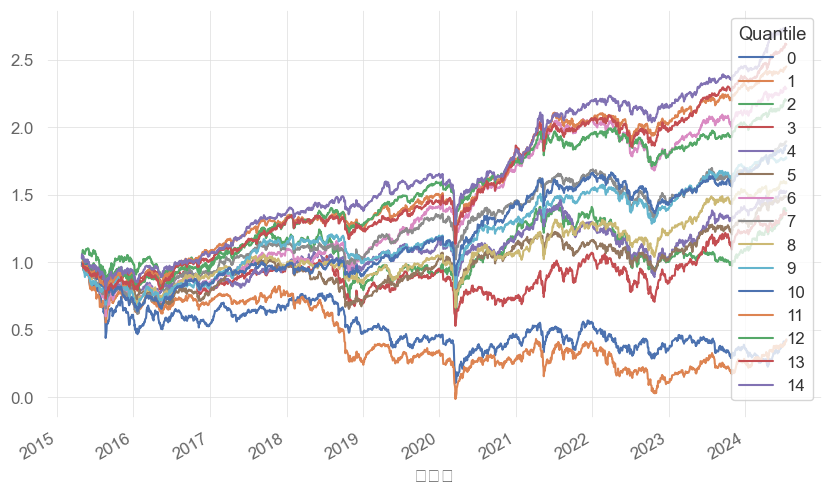

In [29]:
portfolio, positions= backtest_daily_stocksort(q = 15, market_cap_lb=20000)
((portfolio).cumsum() + 1).plot()

In [25]:
positions[14][positions[14] > 0]['2024-7-16']

證券代碼
5876 上海商銀        0.014706
4942 嘉彰          0.014706
9944 新麗          0.014706
2062 橋椿          0.014706
2609 陽明          0.014706
                   ...   
912000 晨訊科-DR    0.014706
2357 華碩          0.014706
2812 台中銀         0.014706
2883 開發金         0.014706
1717 長興          0.014706
Name: 14, Length: 68, dtype: float64

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  func(*args, **kwargs)
/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  func(*args, **kwargs)
/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:93: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  func(*args, **kwargs)
/Users/stuartlu/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figur

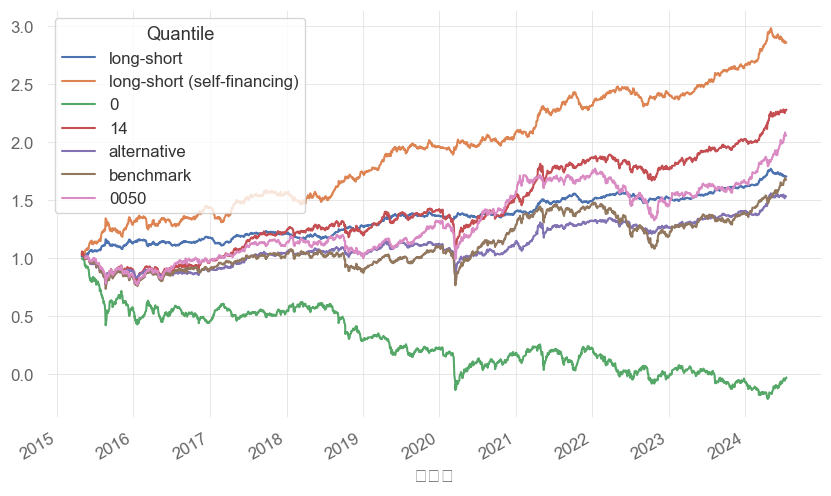

In [31]:
'''
交易成本估算：
    買進： 0.1425%
    賣出： 0.1425%
    證交稅： 0.3%
    每檔進出： 0.585%
    每季共 20*3 = 60 個交易日，平均每日交易成本 約 0.01%
'''
plot_portfolio(portfolio, tc = 0.0001)

In [28]:
return_summary(portfolio)

Annual Sharpe: Quantile
0.0                           -0.662192
1.0                           -0.468120
2.0                           -0.100905
3.0                           -0.054812
4.0                           -0.034961
5.0                            0.302282
6.0                            0.435578
7.0                            0.544781
8.0                            0.671465
9.0                            0.677655
10.0                           0.703472
11.0                           0.937822
12.0                           1.059125
13.0                           1.133564
14.0                           1.454228
long-short (self-financing)    3.473466
long-short                     3.189266
benchmark                      0.646936
0050                           0.833221
reverse                       -1.059832
alternative                    1.244489
dtype: float64
Annual Return (Simple): Quantile
0.0                           -0.116832
1.0                           -0.076118
2.0     

In [30]:
metrics = qs.reports.metrics(portfolio, mode = 'Full')

pd.DataFrame(metrics).to_csv('cap200.csv')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a s

                           0           1           2           3           4           5           6           7           8           9           10          11          12          13          14
-------------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start Period               2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04  2015-05-04
End Period                 2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16  2024-07-16
Risk-Free Rate             0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-01-04   2022-01-04
End Period                 2024-07-17   2024-07-17
Risk-Free Rate             0.0%         0.0%
Time in Market             97.0%        100.0%

Cumulative Return          37.41%       84.34%
CAGR﹪                     9.04%        18.13%

Sharpe                     0.77         3.74
Prob. Sharpe Ratio         88.65%       100.0%
Smart Sharpe               0.68         3.31
Sortino                    1.15         6.31
Smart Sortino              1.02         5.59
Sortino/√2                 0.81         4.46
Smart Sortino/√2           0.72         3.95
Omega                      1.83         1.83

Max Drawdown               -36.04%      -7.48%
Longest DD Days            774          148
Volatility (ann.)          19.28%       6.77%
R^2                        0.0          0.0
Information Ratio          0.03         0.03
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-05-03,2024-07-04,2024-07-17,76,-7.482359,-7.370763
2,2022-06-06,2022-07-04,2022-10-31,148,-5.840516,-5.679539
3,2022-11-25,2022-12-29,2023-02-24,92,-2.172876,-2.096660
4,2024-01-04,2024-01-08,2024-01-29,26,-1.716050,-1.464391
5,2023-10-17,2023-10-24,2023-10-31,15,-1.578689,-1.390831


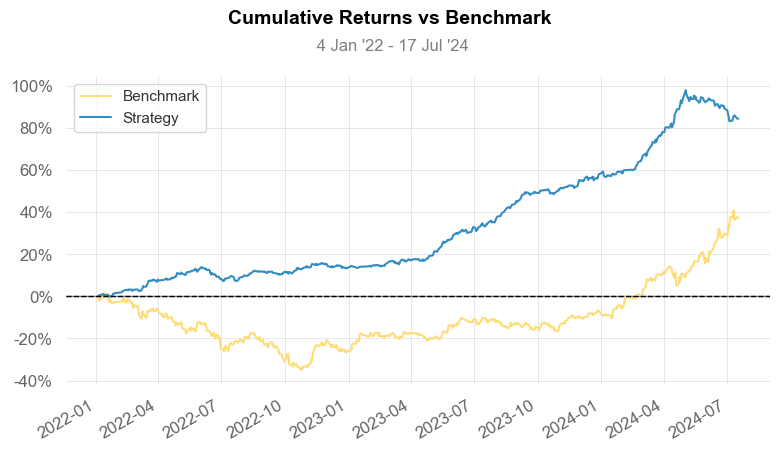

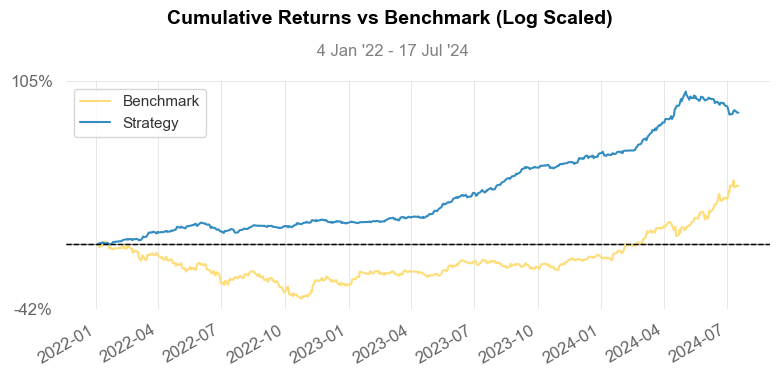

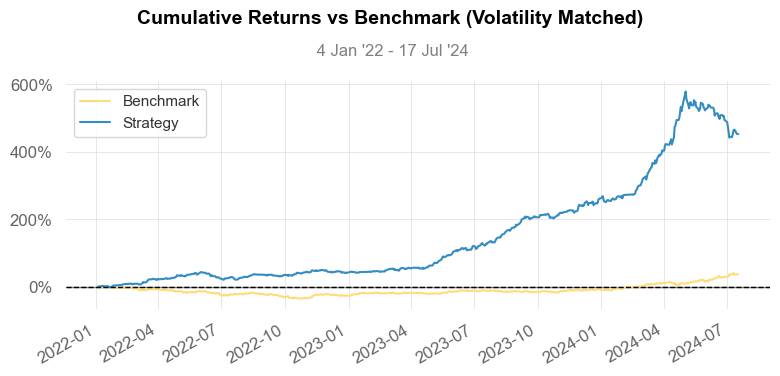

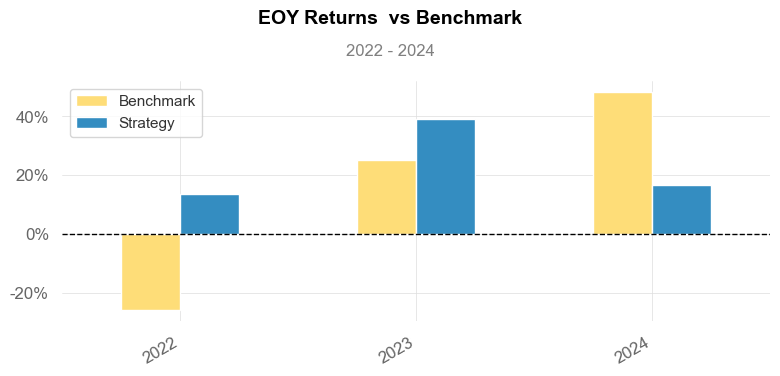

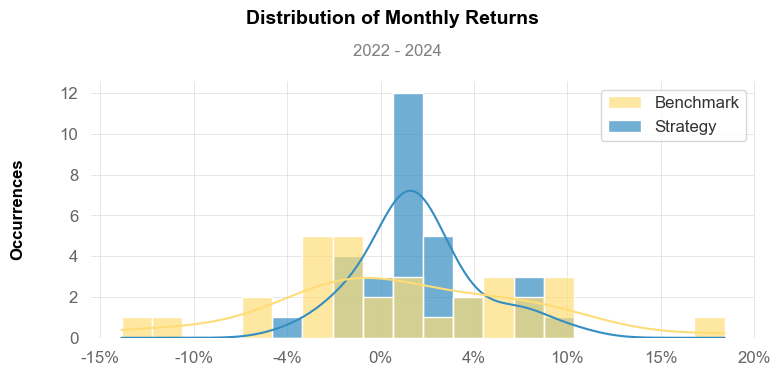

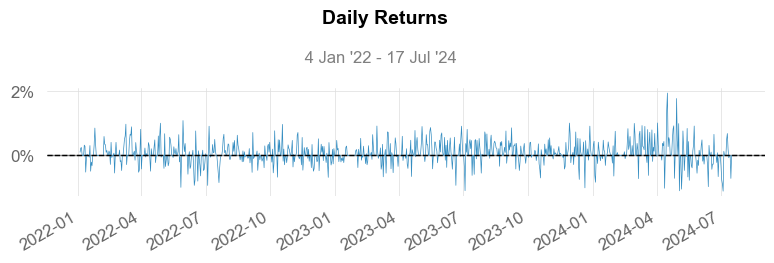

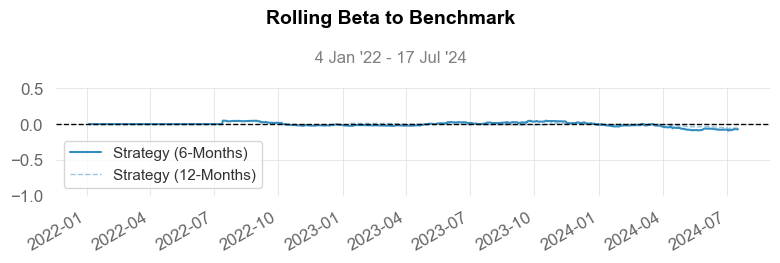

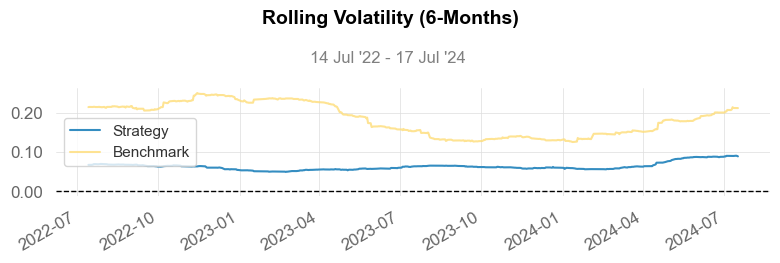

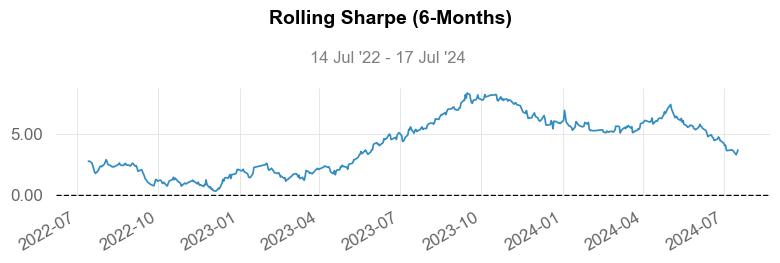

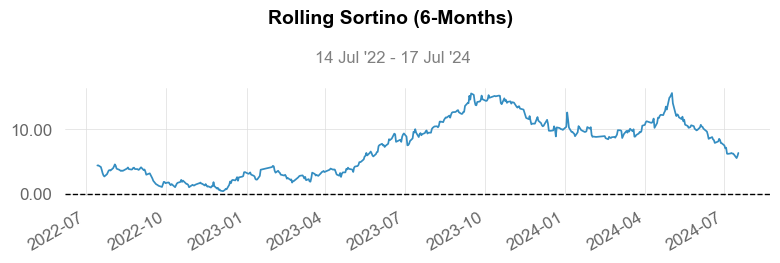

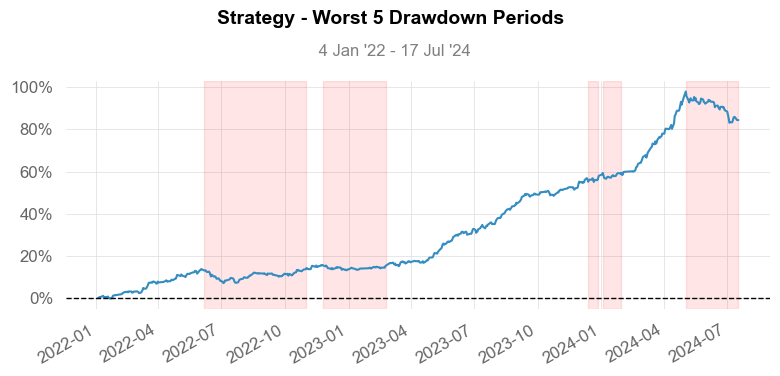

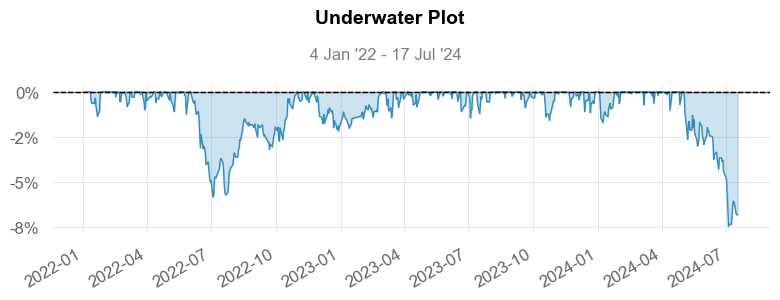

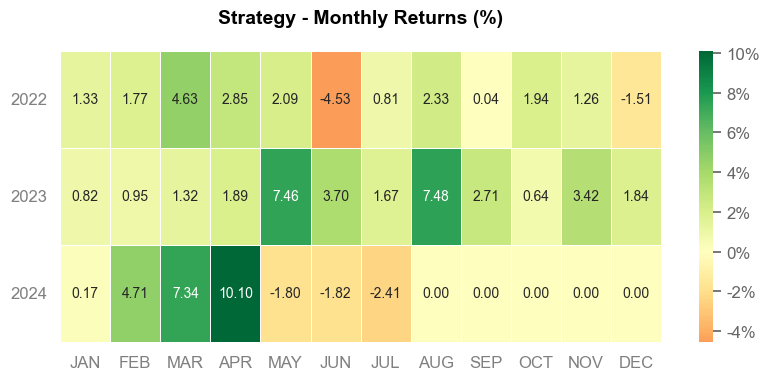

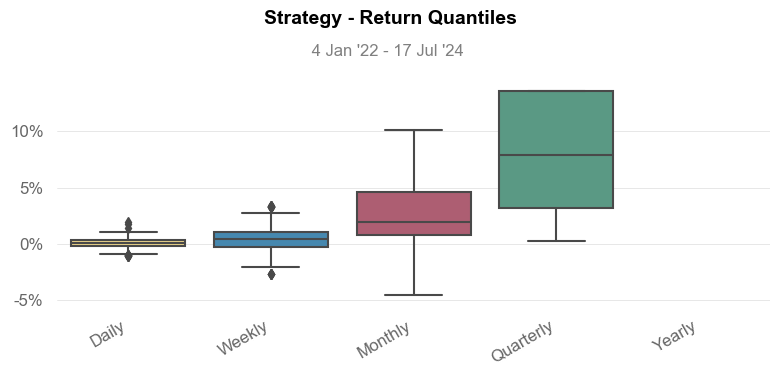

In [32]:
qs.reports.full(portfolio.loc['2022-01-01':, 'long-short (self-financing)'], benchmark=portfolio['0050'], active_returns = False)

In [ ]:
import quantstats as qs

qs.stats.sharpe(portfolio)
qs.plots.snapshot(portfolio[['long', 'short']])

In [ ]:
qs.reports.basic(portfolio[['long', 'short']])

In [ ]:
def backtest(data, clf, features_used):
    history = data.copy()
    history['logistic prediction'] = clf.predict(data[features_used])
    history = history.reset_index()

    dates = sorted(list(set(history['年月'])))

    seasonal_returns_long = [1]
    seasonal_returns_short = [1]
    for date in dates:
        print(date)
        current_stocks = history[history['年月'] == date]
        buy_stock = current_stocks[current_stocks['logistic prediction'] == True]
        sell_stock = current_stocks[current_stocks['logistic prediction'] == False]

        print('Long stocks: ' + str(list(buy_stock['證券代碼'])))
        print('Short stocks: ' + str(list(sell_stock['證券代碼'])))
        print(f'Stock bought: {len(list(buy_stock["證券代碼"]))}, Stock shorted: {len(list(sell_stock["證券代碼"]))}, Total: {len(list(buy_stock["證券代碼"]))+len(list(sell_stock["證券代碼"]))}')
        long = buy_stock['Seasonal Return'].mean()
        short = -sell_stock['Seasonal Return'].mean()
        seasonal_returns_long.append(long)
        seasonal_returns_short.append(short)


    long_portfolio = pd.Series(seasonal_returns_long)
    long_portfolio.cumsum().plot()
    short_portfolio = pd.Series(seasonal_returns_short)
    short_portfolio.cumsum().plot()

    long_short_portfolio = (long_portfolio + short_portfolio)/2
    long_short_portfolio.cumsum().plot()


backtest(data_test, reg, features_used)


'''
history = data_test.copy()
history['logistic prediction'] = reg.predict(data_test[features_used])
history = history.reset_index()

dates = sorted(list(set(history['年月'])))

seasonal_returns_long = [1]
seasonal_returns_short = [1]
for date in dates:
    print(date)
    current_stocks = history[history['年月'] == date]
    buy_stock = current_stocks[current_stocks['logistic prediction'] == True]
    print(list(buy_stock['證券代碼']))
    sell_stock = current_stocks[current_stocks['logistic prediction'] == False]
    long = buy_stock['Seasonal Return'].mean()
    short = -sell_stock['Seasonal Return'].mean()
    seasonal_returns_long.append(long)
    seasonal_returns_short.append(short)


long_portfolio = pd.Series(seasonal_returns_long)
long_portfolio.cumsum().plot()
short_portfolio = pd.Series(seasonal_returns_short)
short_portfolio.cumsum().plot()

long_short_portfolio = (long_portfolio + short_portfolio)/2
long_short_portfolio.cumsum().plot()

'''
